Enter your username (used for marking):

In [78]:
username = 'acp22elc'

## Question 1: Logistic regression and PCA [13 marks]

MedMNIST is a collection of healthcase based datasets that are pre-processed to match to format of the original MNIST dataset. In this questions, you will perform logistic regression and dimension reduction using PCA on the **PneumoniaMNIST** dataset from the MedMNIST. The task for this dataset is to detect whether a chest X-ray shows signs of Pneumonia or not and is therefore a binary classification task.


### 1.1: Data download [1 mark]

The code cell belows provides the code to download the dataset as a compressed numpy file directly from the [MedMNIST website](https://doi.org/10.5281/zenodo.6496656
). If you prefer, you can follow the instructions at https://github.com/MedMNIST/MedMNIST to download and load the data.



In [79]:
import numpy as np
import urllib.request
import os
import torch
np.random.seed(220186281)
torch.manual_seed(220186281)

# Download the dataset to the local folder
urllib.request.urlretrieve('https://zenodo.org/record/6496656/files/pneumoniamnist.npz?download=1', 'pneumoniamnist.npz')

# Load the compressed numpy array file
dataset = np.load('./pneumoniamnist.npz')

# The loaded dataset contains each array internally
for key in dataset.keys():
    print(key, dataset[key].shape, dataset[key].dtype)

train_images (4708, 28, 28) uint8
val_images (524, 28, 28) uint8
test_images (624, 28, 28) uint8
train_labels (4708, 1) uint8
val_labels (524, 1) uint8
test_labels (624, 1) uint8


**1.1a** After downloading the data, merge the validation set into the training set and reshape the images so that each is a 1D array. Then scale the pixel values so they are in the range [0,1].

In [80]:
# Write your code here.
#merge validation set into training set
train_images = np.concatenate((dataset['train_images'], dataset['val_images']), axis=0)
train_labels = np.concatenate((dataset['train_labels'], dataset['val_labels']), axis=0)
test_images = dataset['test_images']
test_labels = dataset['test_labels']
#reshape images so that each is a 1D array
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)
print(train_images)
#normalise images
train_images = train_images/255
test_images = test_images/255
print(train_images)

[[ 92 108 117 ... 168 154 139]
 [115 118 117 ... 183 176 169]
 [149 146 147 ... 188 169 157]
 ...
 [126 145 154 ... 181 175 168]
 [  3   0   3 ... 158 162 152]
 [ 64  69  80 ... 202 196 186]]
[[0.36078431 0.42352941 0.45882353 ... 0.65882353 0.60392157 0.54509804]
 [0.45098039 0.4627451  0.45882353 ... 0.71764706 0.69019608 0.6627451 ]
 [0.58431373 0.57254902 0.57647059 ... 0.7372549  0.6627451  0.61568627]
 ...
 [0.49411765 0.56862745 0.60392157 ... 0.70980392 0.68627451 0.65882353]
 [0.01176471 0.         0.01176471 ... 0.61960784 0.63529412 0.59607843]
 [0.25098039 0.27058824 0.31372549 ... 0.79215686 0.76862745 0.72941176]]


### 1.2: Dimensional reduction and training [6 marks]

**1.2a** Using the Scikit-learn PCA class, transform the training and test data into **at least seven** different sets of reduced dimensions, i.e create 7 alternate datsets with ($k_1, k_2, ..., k_7$) number of features. **Briefly explain** your choice reduced features. Keep a copy of the unreduced data so that in total you have **eight** datasets.


You should fit the tranformation based on the training data and use that to transform the test data. You can find details of the PCA transformation class [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

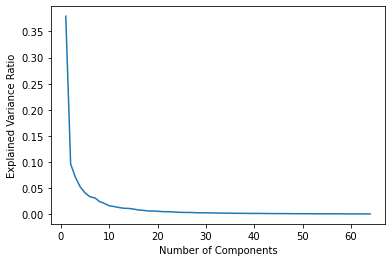

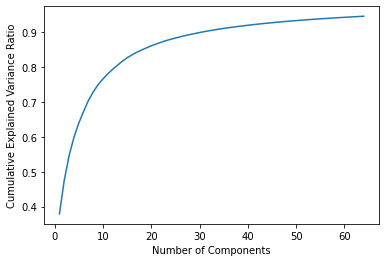

In [81]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=64)

# fit the PCA class to our training data.
pca.fit(train_images)

plt.plot(np.arange(1,65), pca.explained_variance_ratio_)
# Plotting using a log scale might show more information
#plt.yscale('log')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.show()

plt.plot(np.arange(1,65), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.show()


In [82]:
# Write your code here.
from sklearn.decomposition import PCA
out = []
outtest = []
pcas = []
#we go from 2 features to 128 features that explains from 47% to 97% of the variance
#which is a good spread since we also have the original data which which will obviously explain 100% 
for i in range(1,8):
    pca = PCA(n_components=2**i)
    out.append(pca.fit_transform(train_images))
    #print("Fraction of variance in each component:", pca.explained_variance_ratio_)
    print("Total explained variance:", pca.explained_variance_ratio_.sum() )
    outtest.append(pca.transform(test_images)) # we only fit the training set not the test set
    pcas.append(pca)
out.append(train_images)
outtest.append(test_images)
for i in range(len(out)):
    print(out[i].shape)


Total explained variance: 0.47537353213694855
Total explained variance: 0.5982469137865378
Total explained variance: 0.7285928810759683
Total explained variance: 0.8346380640164088
Total explained variance: 0.9040149093941194
Total explained variance: 0.9455524503083876
Total explained variance: 0.9725841816549
(5232, 2)
(5232, 4)
(5232, 8)
(5232, 16)
(5232, 32)
(5232, 64)
(5232, 128)
(5232, 784)



**1.2b** Train **eight** logistic regression classifiers (LRC): one on the original features (unreduced), and seven on PCA features with seven different dimensions in 1.2a, i.e., LRC on $k_1$ PCA features; LRC on $k_2$ PCA features; ..., LRC on $k_7$ PCA features and LRC on the unreduced data. You will need to decide on any options for the logistic regression fitting and **explain** which choices you make.
You can use the Scikit Learn Logistic Regression classifier, further information is given [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).



In [83]:
# Write your code here.
from sklearn.linear_model import LogisticRegression
models = []
for i in range(len(out)):
    model = LogisticRegression()
    model.max_iter = 10000
    model.fit(out[i], train_labels.ravel())
    models.append(model)


### 1.3: Model evaluation [6 marks]

**1.3b** For each of the trained classifiers in 1.2b, calculate the classification accuracy on the training data and the test data. Extract the total explained variance by summing the `PCA.explained_variance_ratio_` for each of your PCA transformations. **Plot** the training accuracy and test accuracy against the total explained variance at each $k_n$. You should include the results for the case trained on the original features, which corresponds to a total explained variance of 1.

2
Accuracy on training set: 0.8797782874617737
Accuracy on test set: 0.8157051282051282
Total explained variance: 0.47537353213694855
4
Accuracy on training set: 0.8920107033639144
Accuracy on test set: 0.844551282051282
Total explained variance: 0.5982469137865378
8
Accuracy on training set: 0.9235474006116208
Accuracy on test set: 0.8028846153846154
Total explained variance: 0.7285928810759683
16
Accuracy on training set: 0.9418960244648318
Accuracy on test set: 0.8333333333333334
Total explained variance: 0.8346380640164088
32
Accuracy on training set: 0.9543195718654435
Accuracy on test set: 0.8221153846153846
Total explained variance: 0.9040149093941194
64
Accuracy on training set: 0.9619648318042814
Accuracy on test set: 0.844551282051282
Total explained variance: 0.9455524503083876
128
Accuracy on training set: 0.9655963302752294
Accuracy on test set: 0.8397435897435898
Total explained variance: 0.9725841816549
784
Accuracy on training set: 0.9713302752293578
Accuracy on test se

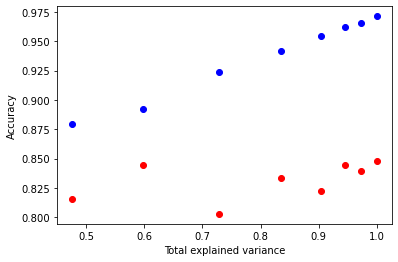

In [84]:
# Write your code here.
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
for i in range(len(out)):
    print(out[i].shape[1])
    training_acc = accuracy_score(train_labels, models[i].predict(out[i]))
    test_acc = accuracy_score(test_labels, models[i].predict(outtest[i]))
    print("Accuracy on training set:", training_acc)
    print("Accuracy on test set:",  test_acc)
    total_explained_variance = 1
    if(i < len(out)-1):
        total_explained_variance = pcas[i].explained_variance_ratio_.sum()
    print("Total explained variance:", total_explained_variance)
    #plot the training and test accuracy against total explained variance
    plt.scatter(total_explained_variance, training_acc, color='blue')
    plt.scatter(total_explained_variance, test_acc, color='red')
plt.xlabel('Total explained variance')
plt.ylabel('Accuracy')
plt.show()
    
    

**1.3b** Describe at least **two** relevant observations from the evaluation results above.

In [85]:
#While both training accuracy and test accuracy seem to trend upwards, test accuracy is more varied in results
#32 seems to be enough to get most of the variance explained and a good accuracy which is supported by the graph in the beginning of the question

## Question 2: Convolutional neural networks for image recognition [16 marks]

Fashion-MNIST is a dataset of Zalando's article images. It consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes: 0=T-shirt/top; 1=Trouser; 2=Pullover; 3=Dress; 4=Coat; 5=Sandal; 6=Shirt; 7=Sneaker; 8=Bag; 9=Ankle boot.

It is available online at https://github.com/zalandoresearch/fashion-mnist but here we will use the version built into PyTorch as part of the TorchVision library [see here for  documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST).

In this question, you should PyTorch to train various forms of neural network models to classify these images. You can refer to Lab 7 on how to define and train neural networks with PyTorch. 

### 2.1: Data download and inspection [3 marks]

**2.1a** Use the PyTorch Torchvision API to load both the train and test parts of the Fashion-MNIST dataset. You can use the code used in Lab 7 to load the CIFAR10 as a basis for this.

In [114]:
# Write your code here.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
np.random.seed(220186281)
torch.manual_seed(220186281)


#transform = transforms.Compose([transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])
trainset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
                                        #Load the test data
testset = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('tshirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'angleboot')

print('Training set size:', len(trainset))
print('Test set size:',len(testset))


Training set size: 60000
Test set size: 10000


**2.1b** Use the `torch.utils.data.random_split` function to split the 60,000 training set into 2 subsets: the first part will be used for training, the second part will be used for validation. You must choose a sensible split of this into the training and validation sets. Create a DataLoader for each of the train, validation, and test splits.

In [115]:
# Write your code here.
#split
split = int(len(trainset)*0.8)
trainset, valset = torch.utils.data.random_split(trainset, [split, len(trainset)-split])
print('training size:', len(trainset))
print('val size:',len(valset))
#Dataloaders
batchSize=8

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchSize, shuffle=True, num_workers=2)#TODO: should batch sizebe *2 and shuffle be false?
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize*2, shuffle=False, num_workers=2)


training size: 48000
val size: 12000


**2.1c** Display 2 example images from each of the classes (20 images in total).

{'tshirt': 2, 'trouser': 2, 'pullover': 2, 'dress': 2, 'coat': 2, 'sandal': 2, 'shirt': 2, 'sneaker': 2, 'bag': 2, 'angleboot': 2}


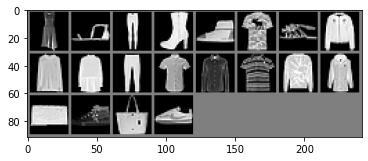

torch.Size([1, 28, 28])


In [116]:
# Write your code here.
def imshow(img):
    img = img / 2 + 0.5     # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #rearrange dimensions to numpy format for disply
    plt.show()


class_images = {}
for i in range(len(classes)):
    class_images[classes[i]] = 2
print(class_images)
    
imagesx =[]
while(True):
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    for i in range(len(labels)):
        if(class_images[classes[labels[i]]] > 0):
            imagesx.append(images[i])
            #imshow(images[i])
            #print(classes[labels[i]])
            class_images[classes[labels[i]]] -= 1
            #print(class_images[classes[labels[i]]])
    if(all(value == 0 for value in class_images.values())):
        break
imshow(torchvision.utils.make_grid(imagesx))
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images[0].shape)

### 2.2: Network training [8 marks]

In this section you will train a set of neural network models to classify the Fashion-MNIST data set. Only the number of convolutional (Conv) layers and the number of fully connected (FC) layers will be specified below. You are free to design other aspects of the network. For example, you can use other types of operation (e.g. padding), layers (e.g. pooling, or preprocessing (e.g. augmentation), and you choose the number of units/neurons in each layer. Likewise, you may choose the number of epochs and many other settings according to your accessible computational power. You should choose sensible values for the batch size and learning rate. If you wish, you may use alternate optimisers, such as [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

When training each model you should keep track of the following values:
1. Training accuracy
2. Validation accuracy
3. Test accuracy

Remember the accuracy is the number of correct classifications out of that portion of the dataset.

In [117]:
## THIS IS THE TEST FUNCTION
def test(cnn):
    correct = 0
    total = 0
    with torch.no_grad():  #testing phase, no need to compute the gradients to save time
        for data in trainloader:
            images, labels = data
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the training images: %d %%' % (100 * correct / total))
    train_accuracy = 100 * correct / total

    correct = 0
    total = 0
    with torch.no_grad():  #testing phase, no need to compute the gradients to save time
        for data in valloader:
            images, labels = data
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the validation images: %d %%' % (100 * correct / total))
    val_accuracy = 100 * correct / total
    correct = 0
    total = 0
    with torch.no_grad():  #testing phase, no need to compute the gradients to save time
        for data in testloader:
            images, labels = data
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    test_accuracy = 100 * correct / total
    return train_accuracy, val_accuracy, test_accuracy

**2.2a** Train a neural network composed of **2 fully connected layers** with an activation function of your choice. Train the model on the training set, use the validation set to choose the best design among **at least three different** choices, and test the chosen model on the test set.

Remember that your dataloader will give you a 2D image. The CNNs can process these but your fully connected (`nn.Linear`) layers are expecting each sample to be a vector.


In [118]:
class CNNa1(nn.Module):
    def __init__(self):
        super(CNNa1, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNNa2(nn.Module):
    def __init__(self):
        super(CNNa2, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNNa3(nn.Module):
    def __init__(self):
        super(CNNa3, self).__init__()
        self.fc1 = nn.Linear(784, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train(myCNN, PATH):
    criterion = nn.CrossEntropyLoss() 
    batch_size=64
    learning_rate=1e-3
    optimizer = torch.optim.Adam(myCNN.parameters(), lr=learning_rate, weight_decay=1e-5)
    outputs = []
    running_loss = 0.0
    for epoch in range(2):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = myCNN(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 1000 == 999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0  
    torch.save(myCNN.state_dict(), PATH)
    return myCNN

myCNNa1 = CNNa1()
myCNNa2 = CNNa2()
myCNNa3 = CNNa3()
train(myCNNa1, 'data/2.2a1.pth')
train(myCNNa2, 'data/2.2a2.pth')
train(myCNNa3, 'data/2.2a3.pth')


[1,  1000] loss: 0.649
[1,  2000] loss: 0.519
[1,  3000] loss: 0.506
[1,  4000] loss: 0.472
[1,  5000] loss: 0.460
[1,  6000] loss: 0.432
[2,  1000] loss: 0.428
[2,  2000] loss: 0.398
[2,  3000] loss: 0.408
[2,  4000] loss: 0.386
[2,  5000] loss: 0.399
[2,  6000] loss: 0.387
[1,  1000] loss: 0.671
[1,  2000] loss: 0.541
[1,  3000] loss: 0.480
[1,  4000] loss: 0.461
[1,  5000] loss: 0.450
[1,  6000] loss: 0.431
[2,  1000] loss: 0.409
[2,  2000] loss: 0.394
[2,  3000] loss: 0.389
[2,  4000] loss: 0.394
[2,  5000] loss: 0.394
[2,  6000] loss: 0.380
[1,  1000] loss: 0.700
[1,  2000] loss: 0.516
[1,  3000] loss: 0.470
[1,  4000] loss: 0.477
[1,  5000] loss: 0.441
[1,  6000] loss: 0.429
[2,  1000] loss: 0.412
[2,  2000] loss: 0.419
[2,  3000] loss: 0.403
[2,  4000] loss: 0.408
[2,  5000] loss: 0.390
[2,  6000] loss: 0.374


CNNa3(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [119]:
loadCNN = CNNa1()
loadCNN.load_state_dict(torch.load('data/2.2a1.pth'))
train_accuracy_a1, val_accuracy_a1, test_accuracy_a1 = test(loadCNN)

loadCNN = CNNa2()
loadCNN.load_state_dict(torch.load('data/2.2a2.pth'))
train_accuracy_a2, val_accuracy_a2, test_accuracy_a2 = test(loadCNN)

loadCNN = CNNa3()
loadCNN.load_state_dict(torch.load('data/2.2a3.pth'))
train_accuracy_a3, val_accuracy_a3, test_accuracy_a3 = test(loadCNN)

Accuracy of the network on the training images: 86 %
Accuracy of the network on the validation images: 85 %
Accuracy of the network on the test images: 84 %
Accuracy of the network on the training images: 85 %
Accuracy of the network on the validation images: 83 %
Accuracy of the network on the test images: 83 %
Accuracy of the network on the training images: 86 %
Accuracy of the network on the validation images: 85 %
Accuracy of the network on the test images: 84 %


**2.2b** Define and train using a neural network composed of **2 convolutional layers and 2 fully connected layers**. Train the model on the training set, use the validation set to choose the best design among **at least three different** choices, and test the chosen model on the test set.

In [92]:
class CNNb1(nn.Module):
    def __init__(self):
        super(CNNb1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
class CNNb2(nn.Module):
    def __init__(self):
        super(CNNb2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.fc1 = nn.Linear(20 * 5 * 5, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 20 * 5 * 5)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNNb3(nn.Module):
    def __init__(self):
        super(CNNb3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 8) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 8)
        self.fc1 = nn.Linear(16 * 1 * 1, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 16 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

        

def train(myCNN, PATH):
    criterion = nn.CrossEntropyLoss() 
    batch_size=64
    learning_rate=1e-3
    optimizer = torch.optim.Adam(myCNN.parameters(), lr=learning_rate, weight_decay=1e-5)
    outputs = []
    running_loss = 0.0
    for epoch in range(2):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = myCNN(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 1000 == 999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0
    torch.save(myCNN.state_dict(), PATH)
    return myCNN


myCNNb1 = CNNb1()
myCNNb2 = CNNb2()
myCNNb3 = CNNb3()
train(myCNNb1, 'data/2.2b1.pth')
train(myCNNb2, 'data/2.2b2.pth')
train(myCNNb3, 'data/2.2b3.pth')


[1,  1000] loss: 0.784
[1,  2000] loss: 0.532
[1,  3000] loss: 0.487
[1,  4000] loss: 0.433
[1,  5000] loss: 0.411
[1,  6000] loss: 0.385
[2,  1000] loss: 0.364
[2,  2000] loss: 0.371
[2,  3000] loss: 0.347
[2,  4000] loss: 0.341
[2,  5000] loss: 0.321
[2,  6000] loss: 0.346
[1,  1000] loss: 0.637
[1,  2000] loss: 0.483
[1,  3000] loss: 0.434
[1,  4000] loss: 0.390
[1,  5000] loss: 0.394
[1,  6000] loss: 0.394
[2,  1000] loss: 0.350
[2,  2000] loss: 0.356
[2,  3000] loss: 0.338
[2,  4000] loss: 0.332
[2,  5000] loss: 0.321
[2,  6000] loss: 0.329
[1,  1000] loss: 0.804
[1,  2000] loss: 0.548
[1,  3000] loss: 0.529
[1,  4000] loss: 0.451
[1,  5000] loss: 0.450
[1,  6000] loss: 0.450
[2,  1000] loss: 0.407
[2,  2000] loss: 0.418
[2,  3000] loss: 0.384
[2,  4000] loss: 0.383
[2,  5000] loss: 0.386
[2,  6000] loss: 0.392


CNNb3(
  (conv1): Conv2d(1, 32, kernel_size=(8, 8), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [93]:
loadCNN = CNNb1()
loadCNN.load_state_dict(torch.load('data/2.2b1.pth'))
train_accuracy_b1, val_accuracy_b1, test_accuracy_b1 = test(loadCNN)

loadCNN = CNNb2()
loadCNN.load_state_dict(torch.load('data/2.2b2.pth'))
train_accuracy_b2, val_accuracy_b2, test_accuracy_b2 = test(loadCNN)

loadCNN = CNNb3()
loadCNN.load_state_dict(torch.load('data/2.2b3.pth'))
train_accuracy_b3, val_accuracy_b3, test_accuracy_b3 = test(loadCNN)

Accuracy of the network on the training images: 88 %
Accuracy of the network on the validation images: 87 %
Accuracy of the network on the test images: 87 %
Accuracy of the network on the training images: 88 %
Accuracy of the network on the validation images: 86 %
Accuracy of the network on the test images: 86 %
Accuracy of the network on the training images: 87 %
Accuracy of the network on the validation images: 86 %
Accuracy of the network on the test images: 86 %


**2.2c** Train a neural network composed of **3 convolutional layers and 3 fully connected layers**. Train the model on the training set, use the validation set to choose the best design among **at least three different** choices, and test the chosen model on the test set.

In [94]:
class CNNc1(nn.Module):
    def __init__(self):
        super(CNNc1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 2)
        self.fc1 = nn.Linear(32 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = F.elu(self.conv3(x))
        #print(x.shape)
        x = x.view(-1, 32 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

class CNNc2(nn.Module):
    def __init__(self):
        super(CNNc2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 2)
        self.fc1 = nn.Linear(32 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = x.view(-1, 32 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class CNNc3(nn.Module):
    def __init__(self):
        super(CNNc3, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 2) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(20, 40, 2)
        self.fc1 = nn.Linear(40 * 2 * 2, 80)
        self.fc2 = nn.Linear(80, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x)))
        #print(x.shape)
        x = x.view(-1, 40 * 2 * 2)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x
        
def train(myCNN, PATH):
    criterion = nn.CrossEntropyLoss() 
    batch_size=64
    learning_rate=1e-3
    optimizer = torch.optim.Adam(myCNN.parameters(), lr=learning_rate, weight_decay=1e-5)
    outputs = []
    running_loss = 0.0
    for epoch in range(2):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = myCNN(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 1000 == 999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0
    torch.save(myCNN.state_dict(), PATH)


myCNNc1 = CNNc1()
train(myCNNc1, 'data/2.2c1.pth')
myCNNc2 = CNNc2()
train(myCNNc2, 'data/2.2c2.pth')
myCNNc3 = CNNc3()
train(myCNNc3, 'data/2.2c3.pth')

[1,  1000] loss: 0.761
[1,  2000] loss: 0.530
[1,  3000] loss: 0.479
[1,  4000] loss: 0.450
[1,  5000] loss: 0.420
[1,  6000] loss: 0.396
[2,  1000] loss: 0.381
[2,  2000] loss: 0.367
[2,  3000] loss: 0.369
[2,  4000] loss: 0.352
[2,  5000] loss: 0.342
[2,  6000] loss: 0.339
[1,  1000] loss: 0.978
[1,  2000] loss: 0.686
[1,  3000] loss: 0.602
[1,  4000] loss: 0.549
[1,  5000] loss: 0.543
[1,  6000] loss: 0.515
[2,  1000] loss: 0.467
[2,  2000] loss: 0.457
[2,  3000] loss: 0.454
[2,  4000] loss: 0.432
[2,  5000] loss: 0.421
[2,  6000] loss: 0.400
[1,  1000] loss: 0.883
[1,  2000] loss: 0.603
[1,  3000] loss: 0.560
[1,  4000] loss: 0.509
[1,  5000] loss: 0.479
[1,  6000] loss: 0.453
[2,  1000] loss: 0.422
[2,  2000] loss: 0.416
[2,  3000] loss: 0.401
[2,  4000] loss: 0.400
[2,  5000] loss: 0.399
[2,  6000] loss: 0.397


In [95]:
loadCNN = CNNc1()
loadCNN.load_state_dict(torch.load('data/2.2c1.pth'))
train_accuracy_c1, val_accuracy_c1, test_accuracy_c1 = test(loadCNN)

loadCNN = CNNc2()
loadCNN.load_state_dict(torch.load('data/2.2c2.pth'))
train_accuracy_c2, val_accuracy_c2, test_accuracy_c2 = test(loadCNN)

loadCNN = CNNc3()
loadCNN.load_state_dict(torch.load('data/2.2c3.pth'))
train_accuracy_c3, val_accuracy_c3, test_accuracy_c3 = test(loadCNN)

Accuracy of the network on the training images: 88 %
Accuracy of the network on the validation images: 87 %
Accuracy of the network on the test images: 87 %
Accuracy of the network on the training images: 84 %
Accuracy of the network on the validation images: 84 %
Accuracy of the network on the test images: 83 %
Accuracy of the network on the training images: 86 %
Accuracy of the network on the validation images: 85 %
Accuracy of the network on the test images: 85 %


### 2.3: Comparison of model performance [5 marks]

**2.3a** In separate **plots**, show the training accuracy, validation accuracy and test accuracy for each of these models.


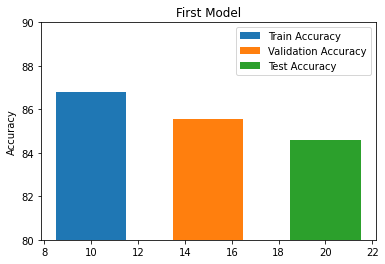

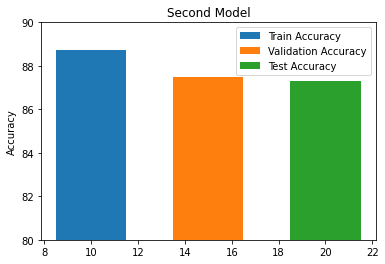

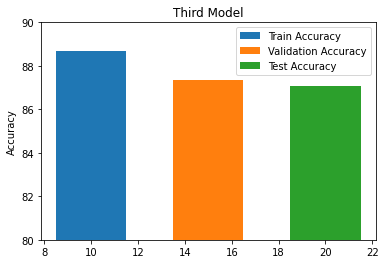

In [96]:
# Write your code here.
plt.bar(10, train_accuracy_a1, 3, label='Train Accuracy')
plt.bar(15, val_accuracy_a1, 3, label='Validation Accuracy')
plt.bar(20, test_accuracy_a1, 3, label='Test Accuracy')
plt.ylim(80, 90)
plt.legend()
plt.ylabel('Accuracy')
plt.title('First Model')
plt.show()

plt.bar(10, train_accuracy_b1, 3, label='Train Accuracy')
plt.bar(15, val_accuracy_b1, 3, label='Validation Accuracy')
plt.bar(20, test_accuracy_b1, 3, label='Test Accuracy')
plt.ylim(80, 90)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Second Model')
plt.show()

plt.bar(10, train_accuracy_c1, 3, label='Train Accuracy')
plt.bar(15, val_accuracy_c1, 3, label='Validation Accuracy')
plt.bar(20, test_accuracy_c1, 3, label='Test Accuracy')
plt.ylim(80, 90)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Third Model')
plt.show()


**2.3b** Describe at least **two** observations of the data plotted in this section.

In [97]:
#For each model consistently they performed the best on the training data and the worst on the test data
#Convolutional models seems to outperform the fully connected models

## 3. Denoising Autoencoder [16 marks]

### The CIFAR-10 dataset
In this assignment, we will work on the CIFAR-10 dataset collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton from the University of Toronto. This dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. Each sample is a 3-channel colour images of 32x32 pixels in size. There are 50,000 training images and 10,000 test images.

### 3.1: Data loading and manipulation [3 marks]

**3.1a** Download both the training and test data of the CIFAR-10 dataset, e.g., by following the pytorch CIFAR10 tutorial. You can also download via other ways if you prefer.

In [98]:
# Write your code here.
batchSize=128
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#Load the training data
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=False)

#Load the test data
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, 
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('Training set size:', len(trainset))
print('Test set size:',len(testset))

Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000
Test set size: 10000


**3.1b** Add random noise to all training and test data to generate noisy dataset, e.g., by torch.randn(), with a scaling factor scale, e.g., original image + scale * torch.randn(), and normalise/standardise the pixel values to the original range, e.g., using np.clip(). You may choose any scale value between 0.2 and 0.5.

A random transformation can be applied using a `Lambda` [transform](https://pytorch.org/vision/stable/transforms.html) when composing the load data transform, which looks a little like this:  
`transforms.Lambda(lambda x: x + ..... )`

Note: Before generating the random noise, you MUST set the random seed to your UCard number XXXXXXXXX for reproducibility, e.g., using torch.manual_seed(). This seed needs to be used for all remaining code if there is randomness, for reproducibility.

You may want to create separate dataloaders for the noisy and clear images but make sure they are not shuffling the data so that correct pair of images are being given as input and desired output.

In [99]:
# Write your code here.
torch.manual_seed(220186281)
np.random.seed(220186281)
#add random noise to training data using torch.randn make a new dataloader for noisy ones
scale = 0.2
noisy_trainset = []
print(trainset[i][0].shape)
for i in range(len(trainset)):
    noisy_trainset.append((trainset[i][0] + scale * torch.randn(torch.Size([3, 32, 32])), trainset[i][1]))
noisy_trainloader = torch.utils.data.DataLoader(noisy_trainset, batch_size=batchSize,
                                            shuffle=False)
print('Training set size:', len(noisy_trainset))

torch.Size([3, 32, 32])
Training set size: 50000


**3.1c** Show 20 pairs of original and noisy images.

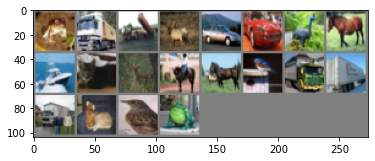

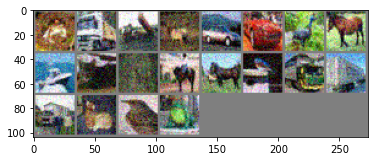

In [100]:
# Write your code here.
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get 20 images from the training set

dataiter = iter(trainloader)
images, labels = dataiter.next()
dataiter_noisy = iter(noisy_trainloader)
noisy_images, noisy_labels = dataiter_noisy.next()



images = images[:20]
noisy_images = noisy_images[:20]
images = np.clip(images, -1, 1)
noisy_images = np.clip(noisy_images, -1, 1)
#print(images.shape[0])
# show images
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(noisy_images))



### 3.2 Applying a Denoising Autoencoder to the modified CIFAR10 [10 marks]

This question uses both the original and noisy CIFAR-10 datasets (all 10 classes).
Read about denoising autoencoders at [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder) and this [short introduction](https://towardsdatascience.com/denoising-autoencoders-explained-dbb82467fc2) or any other sources you like.

**3.2a** Modify the autoencoder architecture in Lab 8 so that it takes colour images as input (i.e., 3 input channels).

In [101]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ELU(),  # activation function
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # conv layer
            nn.ELU(), # activation function 
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0) # conv layer
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=1, padding=0), # conv transpose layer
            nn.ELU(), # activation function
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # conv transpose layer
            nn.ELU(), # activation function
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

**3.2b** Training: feed the noisy training images as input to the autoencoder defined above; use a loss function that computes the reconstruction error between the output of the autoencoder and the respective original images.



In [102]:
# Write your code here.
myCAE = ConvAutoencoder()
print(myCAE)

def train_AE(model, train_loader, noisy_trainloader,  max_epochs=20, print_steps=5):
    #Training (optimisation) parameters
    batch_size=128
    learning_rate=1e-3

    #Choose mean square error loss
    criterion = nn.L1Loss() 

    #Choose the Adam optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    #Specify how the data will be loaded in batches (with random shuffling)
    #train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    #denoised_train_loader = torch.utils.data.DataLoader(denoised_dataset, batch_size=batch_size, shuffle=False)

    #Storage
    #outputs = []
    #inputs = []
    #noisies = []
    #losss = []

    #Start training
    for epoch in range(max_epochs):
        dataloader_iterator = iter(train_loader)
        for i, data1 in enumerate(noisy_trainloader):
            try:
                data2 = next(dataloader_iterator)
            except StopIteration:
                dataloader_iterator = iter(train_loader)
                data2 = next(dataloader_iterator)
            img = data2[0]
            noisy = data1[0]
            recon = model(noisy)
            loss = criterion(recon, img)

            #for i in range(0,recon.shape[0]):
            #    losss.append(criterion(recon[i], img[i]).item())
            #noisies.append(noisy.view(noisy.shape[0], 3, 32, 32).detach().numpy())
            #outputs.append(recon.view(recon.shape[0], 3, 32, 32).detach().numpy())
            #inputs.append(img.view(img.shape[0], 3, 32, 32).detach().numpy())

            loss.backward()
            optimizer.step()  
            optimizer.zero_grad()
          
        if ((epoch % print_steps) == 0) or (epoch +1 == max_epochs):
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss.item()))


        #outputs.append((epoch, img.detach(), recon.detach()),)
        #output = output.view(20, 3, 32, 32)
        #output = output.detach().numpy()

    return #outputs, inputs#, noisies, losss
    
#outputs, inputs, noisies, losss = train_AE(myCAE, trainloader, noisy_trainloader,  max_epochs=21)
train_AE(myCAE, trainloader, noisy_trainloader,  max_epochs=21)
PATH = 'data/3.2b.pth'
torch.save(myCAE.state_dict(), PATH)





ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ELU(alpha=1.0)
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ELU(alpha=1.0)
    (4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)
Epoch:1, Loss:0.1147
Epoch:6, Loss:0.0918
Epoch:11, Loss:0.0901
Epoch:16, Loss:0.0880
Epoch:21, Loss:0.0871


In [103]:
loadCAE = ConvAutoencoder()
loadCAE.load_state_dict(torch.load('data/3.2b.pth'))

<All keys matched successfully>

**3.2c** Testing: evaluate the autoencoder trained in 3.2b on the test datasets (feed noisy images in and compute reconstruction errors on original clean images. Find the worst denoised 30 images (those with the largest reconstruction errors) in the test set and show them in pairs with the original images (60 images to show in total).

10000
Test set size: 10000
(3, 32, 32)


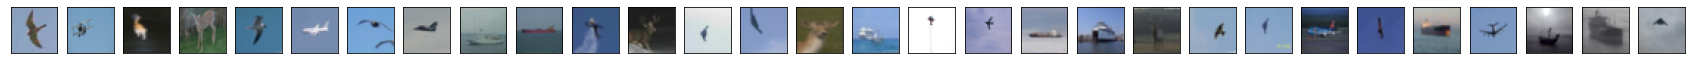

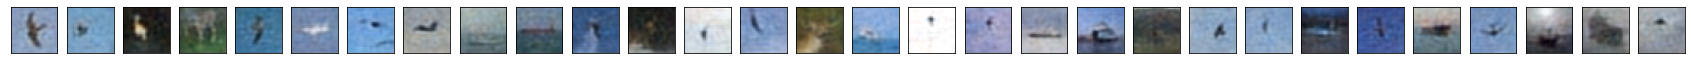

In [104]:
# Write your code here.
torch.manual_seed(41241241)
np.random.seed(41241241)
#add random noise to test data using torch.randn make a new dataloader for noisy ones
scale = 0.2
noisy_testset = []
print(len(testset))
for i in range(len(testset)):
    noisy_testset.append((testset[i][0] + scale * torch.randn(torch.Size([3, 32, 32])), testset[i][1]))
noisy_testloader = torch.utils.data.DataLoader(noisy_testset, batch_size=batchSize,
                                            shuffle=False)
print('Test set size:', len(noisy_testset))

losss = []
noisies = []
outputs = []
inputs = []
model = loadCAE

criterion = nn.L1Loss() 
dataloader_iterator = iter(testloader)
for i, data1 in enumerate(noisy_testloader):
    try:
        data2 = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(testloader)
        data2 = next(dataloader_iterator)
    img = data2[0]
    noisy = data1[0]
    for i in range(len(img)):
        recon = model(noisy[i])
        loss = criterion(recon, img[i])
        #keep lowest 30 losses in losss
        if len(losss) < 30:
            losss.append(loss.item())
            noisies.append(noisy[i].view(1, 3, 32, 32).detach().numpy())
            outputs.append(recon.view(1, 3, 32, 32).detach().numpy())
            inputs.append(img[i].view(1, 3, 32, 32).detach().numpy())
        else:
            if loss.item() < max(losss):
                losss[losss.index(max(losss))] = loss.item()
                noisies[losss.index(max(losss))] = noisy[i].view(1, 3, 32, 32).detach().numpy()
                outputs[losss.index(max(losss))] = recon.view(1, 3, 32, 32).detach().numpy()
                inputs[losss.index(max(losss))] = img[i].view(1, 3, 32, 32).detach().numpy()


def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

print(inputs[1][0].shape)

numImgs=12
plt.figure(figsize=(30, 2))
for k in range(0, 30):
    imgs = inputs[k][0]    
    imgs = np.clip(imgs, -1, 1)
    plt.subplot(2, 30, k+1)
    plt.xticks([])
    plt.yticks([])
    imshow(imgs)

#plt.figure(figsize=(30, 2))
#for k in range(0, 30):
#    noisys = noisies[k][0] 
#    noisys = np.clip(noisys, -1, 1)   
#    plt.subplot(2, 30, k+1)
#    plt.xticks([])
#    plt.yticks([])
#    imshow(noisys)

plt.figure(figsize=(30, 2))
for k in range(0, 30):  
    recon = outputs[k][0]
    recon = np.clip(recon, -1, 1)
    plt.subplot(2, 30, 31+k)
    plt.xticks([])
    plt.yticks([])
    imshow(recon)

**3.2d** Choose at least **two** hyperparameters (e.g learning rate) to vary. Study at least **three** different choices for each hyperparameter. When varying one hyperparameter, all the other hyperparameters can be fixed. **Plot** the reconstruction error with respect to each of these hyper-parameters.

In [107]:
def train_AE_lr_vary(model, train_loader, noisy_trainloader,lr ,  max_epochs=20, print_steps=3):
    #Training (optimisation) parameters
    batch_size=128
    learning_rate=lr

    #Choose mean square error loss
    criterion = nn.L1Loss() 

    #Choose the Adam optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    losses  = []
    #Start training
    for epoch in range(max_epochs):
        dataloader_iterator = iter(train_loader)
        for i, data1 in enumerate(noisy_trainloader):
            try:
                data2 = next(dataloader_iterator)
            except StopIteration:
                dataloader_iterator = iter(train_loader)
                data2 = next(dataloader_iterator)
            img = data2[0]
            noisy = data1[0]
            recon = model(noisy)
            loss = criterion(recon, img)

            loss.backward()
            optimizer.step()  
            optimizer.zero_grad()
          
        if ((epoch % print_steps) == 0) or (epoch +1 == max_epochs):
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss.item()))
            losses.append(loss.item())

    return losses

myCAE1 = ConvAutoencoder()
losses1 = train_AE_lr_vary(myCAE, trainloader, noisy_trainloader, 1e-3, max_epochs=12)
myCAE2 = ConvAutoencoder()
losses2 = train_AE_lr_vary(myCAE, trainloader, noisy_trainloader, 1e-4, max_epochs=12)
myCAE3 = ConvAutoencoder()
losses3 = train_AE_lr_vary(myCAE, trainloader, noisy_trainloader, 1e-5, max_epochs=12)

Epoch:1, Loss:0.0869
Epoch:4, Loss:0.0867
Epoch:7, Loss:0.0864
Epoch:10, Loss:0.0860
Epoch:12, Loss:0.0859
Epoch:1, Loss:0.0842
Epoch:4, Loss:0.0840
Epoch:7, Loss:0.0839
Epoch:10, Loss:0.0838
Epoch:12, Loss:0.0837
Epoch:1, Loss:0.0836
Epoch:4, Loss:0.0835
Epoch:7, Loss:0.0835
Epoch:10, Loss:0.0835
Epoch:12, Loss:0.0835


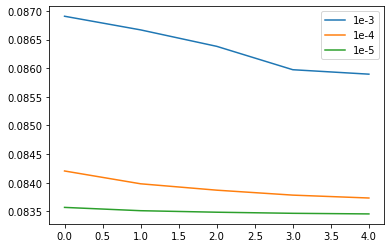

In [108]:
#plot losses1 2 3
plt.plot(losses1, label='1e-3')
plt.plot(losses2, label='1e-4')
plt.plot(losses3, label='1e-5')
plt.legend()
plt.show()

In [111]:
def train_AE_epoch_vary(model, train_loader, noisy_trainloader,  max_epochs=20, print_steps=1):
    #Training (optimisation) parameters
    batch_size=128
    learning_rate=1e-3

    #Choose mean square error loss
    criterion = nn.L1Loss() 

    #Choose the Adam optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    losses  = []
    #Start training
    for epoch in range(max_epochs):
        dataloader_iterator = iter(train_loader)
        for i, data1 in enumerate(noisy_trainloader):
            try:
                data2 = next(dataloader_iterator)
            except StopIteration:
                dataloader_iterator = iter(train_loader)
                data2 = next(dataloader_iterator)
            img = data2[0]
            noisy = data1[0]
            recon = model(noisy)
            loss = criterion(recon, img)

            loss.backward()
            optimizer.step()  
            optimizer.zero_grad()
          
        if ((epoch % print_steps) == 0) or (epoch +1 == max_epochs):
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss.item()))
            losses.append(loss.item())

    return losses

myCAE1 = ConvAutoencoder()
losses1 = train_AE_epoch_vary(myCAE, trainloader, noisy_trainloader, max_epochs=3)
myCAE2 = ConvAutoencoder()
losses2 = train_AE_epoch_vary(myCAE, trainloader, noisy_trainloader, max_epochs=6)
myCAE3 = ConvAutoencoder()
losses3 = train_AE_epoch_vary(myCAE, trainloader, noisy_trainloader, max_epochs=9)

Epoch:1, Loss:0.0855
Epoch:2, Loss:0.0854
Epoch:3, Loss:0.0853
Epoch:1, Loss:0.0855
Epoch:2, Loss:0.0853
Epoch:3, Loss:0.0852
Epoch:4, Loss:0.0851
Epoch:5, Loss:0.0851
Epoch:6, Loss:0.0850
Epoch:1, Loss:0.0851
Epoch:2, Loss:0.0849
Epoch:3, Loss:0.0848
Epoch:4, Loss:0.0848
Epoch:5, Loss:0.0847
Epoch:6, Loss:0.0847
Epoch:7, Loss:0.0847
Epoch:8, Loss:0.0846
Epoch:9, Loss:0.0846


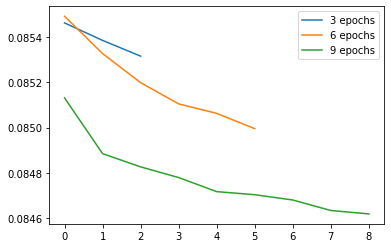

In [112]:
#plot losses1 2 3
plt.plot(losses1, label='3 epochs')
plt.plot(losses2, label='6 epochs')
plt.plot(losses3, label='9 epochs')
plt.legend()
plt.show()

### 3.3 Discussion of results [3 marks]
**3.3a** Describe at least **two** interesting relevant observations from the evaluation results above.

In [106]:
#Higher learning rate seems to be better for actually improving the model but the loss plateus before it reaches the other ones anyways
#More epochs seems to be better for the loss but it takes longer to train